In [1]:
from comet_ml import Experiment
from comet_ml import API
import os
from dotenv import load_dotenv
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibrationDisplay

warnings.filterwarnings("ignore")
load_dotenv('../.env')
COMET_API_KEY = os.getenv('COMET_API_KEY')
COMET_PROJECT_NAME = os.getenv('COMET_PROJECT_NAME')
COMET_WORKSPACE = os.getenv('COMET_WORKSPACE')

In [2]:
def get_registered_comet_model(workspace, model, version, output_path):
    api = API()
    # Download a Registry Model
    file = api.download_registry_model({workspace}, model, version, output_path=output_path, expand=True)
    return file

## Question-1: Regular season


In [3]:
data_regular = pd.read_csv('data/testSet.csv')
data_regular = data_regular.drop(labels='index', axis=1).reset_index(drop=True)
data_regular['Goal'] = data_regular['Goal'].astype(np.int64)
display(data_regular.shape)
data_regular.head()

(68500, 39)

,eventType,period,periodTime,periodType,gameID,teamOfShooter,homeOrAway,xCoord,yCoord,shooter,...,timeFromLastEvent,distanceFromLastEvent,rebound,lastEventAngle,changeInAngleShot,speed,timeSincePowerPlayStarted,numFriendlyNonGoalieSkaters,numOpposingNonGoalieSkaters,strength2
0,Goal,1,00:25,REGULAR,2019020001,Ottawa Senators,away,85.0,-1.0,Brady Tkachuk,...,25.0,85.005882,0.0,NaN,NaN,3.400235,0.0,5.0,5.0,Even
1,Shot,1,01:31,REGULAR,2019020001,Toronto Maple Leafs,home,-32.0,-2.0,Morgan Rielly,...,27.0,29.274562,0.0,NaN,NaN,1.084243,35.0,5.0,4.0,Power Play
2,Shot,1,03:23,REGULAR,2019020001,Ottawa Senators,away,63.0,-6.0,Dylan DeMelo,...,14.0,127.015747,0.0,NaN,NaN,9.072553,0.0,5.0,5.0,Even
3,Shot,1,03:56,REGULAR,2019020001,Toronto Maple Leafs,home,-59.0,-20.0,Morgan Rielly,...,6.0,93.000000,0.0,NaN,NaN,15.500000,0.0,5.0,5.0,Even
4,Shot,1,04:47,REGULAR,2019020001,Toronto Maple Leafs,home,-42.0,-29.0,Tyson Barrie,...,6.0,55.000000,0.0,NaN,NaN,9.166667,0.0,5.0,5.0,Even


In [4]:
# Read and preprocess data
df =data_regular[['distanceFromNet', 'angle', 'Goal']]

df= df.dropna().reset_index(drop=True)
display(df.shape)
df.head()

(68499, 3)

,distanceFromNet,angle,Goal
0,4.123106,75.963757,1
1,57.035077,92.009554,0
2,26.683328,77.005383,0
3,36.055513,123.690068,0
4,55.226805,121.675469,0


### Evaluate Model

In [5]:
Xr1 = df[['distanceFromNet', 'angle']].to_numpy().reshape(-1, 2)
yr = df['Goal'].to_numpy().reshape(-1, 1)

filename = '../tmp/XGBoost_Task5.joblib'
get_registered_comet_model(COMET_WORKSPACE, 'xgboost-task5-model', '1.0.0', '../tmp/')
XGboost = load(filename)

preds1 = XGboost.predict(Xr1)

COMET INFO: Downloading registry model 'xgboost-task5-model', version '1.0.0', stage None from workspace {'meriembchaaben'}...
COMET INFO: Unzipping model to 'C:\\Users\\merie\\OneDrive\\Documents\\Data science\\Milestone2\\IFT6758\\tmp' ...
COMET INFO: done!


In [6]:
target_names = ['Non-goal', 'Goal']
accuracy1 = XGboost.score(Xr1, yr)
brier1 = brier_score_loss(yr, preds1)
print(f'Test accuracy: {accuracy1}' )
print(f'Brier score: {brier1}' )
print('** Classification report **')
print(classification_report(yr, preds1, target_names=target_names))

Test accuracy: 0.9029182907779676
Brier score: 0.09708170922203244
** Classification report **
              precision    recall  f1-score   support

    Non-goal       0.90      1.00      0.95     61851
        Goal       0.47      0.00      0.01      6648

    accuracy                           0.90     68499
   macro avg       0.69      0.50      0.48     68499
weighted avg       0.86      0.90      0.86     68499



## Visualization

XGboost (tuned but trained on distanceFromNet and Angle only): ROC AUC=0.717
Random: ROC AUC=0.500


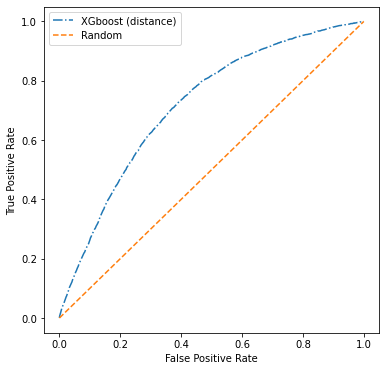

In [7]:
### ROC curve - AUC metric ###

XGboost_probs1 = XGboost.predict_proba(Xr1[:, :])[:,1]


random_clf = DummyClassifier(strategy="uniform").fit(Xr1, yr)
random_probs = random_clf.predict_proba(Xr1[:, :])[:,1]



XGboost_auc1 = roc_auc_score(yr, XGboost_probs1)
random_auc = roc_auc_score(yr, random_probs)


print('XGboost (tuned but trained on distanceFromNet and Angle only): ROC AUC=%.3f' % (XGboost_auc1))

print('Random: ROC AUC=%.3f' % (random_auc))

XGboost_fpr1, XGboost_tpr1, _ = roc_curve(yr, XGboost_probs1)

random_fpr, random_tpr, _ = roc_curve(yr, random_probs)

plt.figure(figsize=(6, 6))

plt.plot(XGboost_fpr1, XGboost_tpr1, linestyle='-.', label='XGboost (distance)')
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('../figures/Regular season_XGboostRsults_ROC.png')

plt.show()

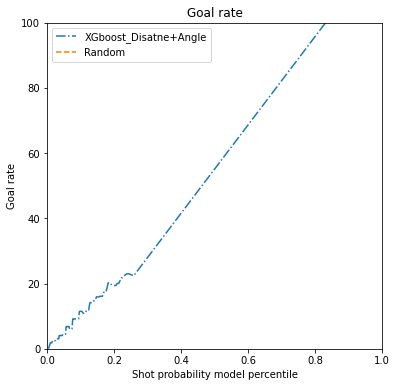

In [8]:
### goal_rate = F(shot probability model percentile) ###
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        r_percentile = np.float32(round(percentile, 2))
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
#             if p<=percentile:
            if np.float32(round(p, 2))==r_percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        if (goals+no_goals==0):
            rate=0
        else:
            rate = goals *100 / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

percentiles1, rates1 = compute_goal_rate_per_percentile(XGboost_probs1, yr)
percentiles4, rates4 = compute_goal_rate_per_percentile(random_probs, yr)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, linestyle='-.', label='XGboost_Disatne+Angle')
plt.plot(percentiles4, rates4, linestyle='--', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()
plt.ylim([0, 100])
plt.xlim([0, 1])
plt.title('Goal rate')

plt.savefig('../figures/Regular season_XGboost-goal_rate_percentile_1.png')

plt.show()

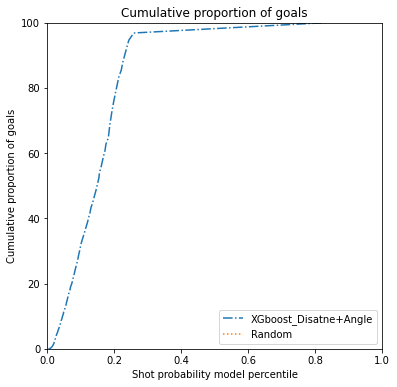

In [9]:
def compute_cumulative_propotion_of_goals_per_percentile(probs, y):
    percentiles = []
    cum_rates = []
    cum_rate = 0
    total_goals = sum(y)
    cum_goals = 0
    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        cum_goals=0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    cum_goals+=1 
        cum_rate = cum_goals * 100 / total_goals
        percentiles.append(percentile)
        cum_rates.append(cum_rate)
    return percentiles, cum_rates


percentiles1, rates1 = compute_cumulative_propotion_of_goals_per_percentile(XGboost_probs1, yr)

percentiles4, rates4 = compute_cumulative_propotion_of_goals_per_percentile(random_probs, yr)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, linestyle='-.', label='XGboost_Disatne+Angle')

plt.plot(percentiles4, rates4, linestyle=':', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative proportion of goals')
plt.legend(loc='lower right')
plt.ylim([0, 100])
plt.xlim([0, 1])
plt.title('Cumulative proportion of goals')

plt.savefig('../figures/Regular season_XGboost-goal_rate_percentile_2.png')

plt.show()

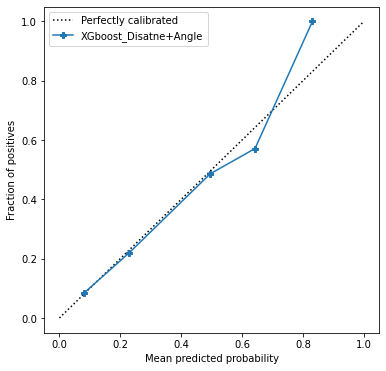

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))


disp1 = CalibrationDisplay.from_estimator(XGboost, Xr1, yr, label='XGboost_Disatne+Angle', marker="P", ax=ax)

ax.legend(loc='upper left')

plt.savefig('../figures/Regular season_XGboost-calibration_diagram2.png')

plt.show()

## Question-2: PlayOffs


In [11]:
data_playoffs = pd.read_csv('data/testSetPlayOff.csv')
data_playoffs = data_playoffs.drop(labels=['index', 'Unnamed: 0'], axis=1).reset_index(drop=True)
data_playoffs['Goal'] = data_playoffs['Goal'].astype(np.int64)
display(data_playoffs.shape)
data_playoffs.head()

(5367, 39)

,eventType,period,periodTime,periodType,gameID,teamOfShooter,homeOrAway,xCoord,yCoord,shooter,...,timeFromLastEvent,distanceFromLastEvent,rebound,lastEventAngle,changeInAngleShot,speed,timeSincePowerPlayStarted,numFriendlyNonGoalieSkaters,numOpposingNonGoalieSkaters,strength2
0,Shot,1,02:18,REGULAR,2019030111,Philadelphia Flyers,home,-56.0,-5.0,Sean Couturier,...,2.0,21.400935,0.0,NaN,NaN,10.700467,0.0,5.0,5.0,Even
1,Shot,1,04:15,REGULAR,2019030111,Montréal Canadiens,away,54.0,-26.0,Joel Armia,...,39.0,97.867257,0.0,NaN,NaN,2.509417,0.0,5.0,5.0,Even
2,Shot,1,04:58,REGULAR,2019030111,Philadelphia Flyers,home,-61.0,38.0,Philippe Myers,...,5.0,45.354162,0.0,NaN,NaN,9.070832,0.0,5.0,5.0,Even
3,Shot,1,05:06,REGULAR,2019030111,Philadelphia Flyers,home,-52.0,-14.0,Ivan Provorov,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,5.0,5.0,Even
4,Shot,1,06:11,REGULAR,2019030111,Philadelphia Flyers,home,-49.0,-32.0,Travis Sanheim,...,4.0,78.771822,0.0,NaN,NaN,19.692956,0.0,5.0,5.0,Even


In [12]:
df_PO =data_playoffs[['distanceFromNet', 'angle', 'Goal']]

df_PO= df_PO.dropna().reset_index(drop=True)
display(df_PO.shape)
df_PO.head()

(5367, 3)

,distanceFromNet,angle,Goal
0,33.376639,98.615648,0
1,43.600459,53.392925,0
2,47.201695,36.384352,0
3,39.560081,110.725559,0
4,51.224994,128.659808,0


## Evaluate Model

In [14]:
X_PO = df_PO[['distanceFromNet', 'angle']].to_numpy().reshape(-1, 2)
y_PO = df_PO['Goal'].to_numpy().reshape(-1, 1)
predsPO = XGboost.predict(X_PO)
print('####### XGBoost Distance+Angle  #######')
target_names = ['Non-goal', 'Goal']
accuracy1 = XGboost.score(X_PO, y_PO)
brier1 = brier_score_loss(y_PO, predsPO)
print(f'Test accuracy: {accuracy1}' )
print(f'Brier score: {brier1}' )
print('** Classification report **')
print(classification_report(y_PO, predsPO, target_names=target_names))

####### XGBoost Distance+Angle  #######
Test accuracy: 0.9118688280231042
Brier score: 0.08813117197689585
** Classification report **
              precision    recall  f1-score   support

    Non-goal       0.91      1.00      0.95      4893
        Goal       0.60      0.01      0.01       474

    accuracy                           0.91      5367
   macro avg       0.76      0.50      0.48      5367
weighted avg       0.88      0.91      0.87      5367



### Visualisation

XGboost (tuned but trained on distanceFromNet and Angle only): ROC AUC=0.696
Random: ROC AUC=0.500


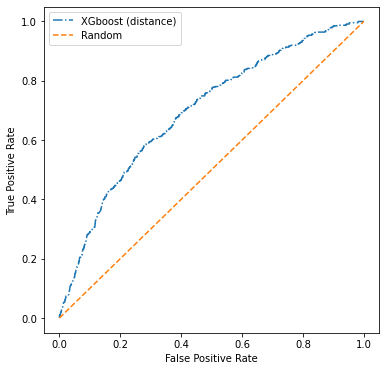

In [15]:
XGboost_probsPlayOff = XGboost.predict_proba(X_PO[:, :])[:,1]


random_clf = DummyClassifier(strategy="uniform").fit(X_PO, y_PO)
random_probs = random_clf.predict_proba(X_PO[:, :])[:,1]



XGboost_auc1 = roc_auc_score(y_PO, XGboost_probsPlayOff)
random_auc = roc_auc_score(y_PO, random_probs)


print('XGboost (tuned but trained on distanceFromNet and Angle only): ROC AUC=%.3f' % (XGboost_auc1))

print('Random: ROC AUC=%.3f' % (random_auc))

XGboost_fpr1, XGboost_tpr1, _ = roc_curve(y_PO, XGboost_probsPlayOff)

random_fpr, random_tpr, _ = roc_curve(y_PO, random_probs)

plt.figure(figsize=(6, 6))

plt.plot(XGboost_fpr1, XGboost_tpr1, linestyle='-.', label='XGboost (distance)')
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig('../figures/PlayOffs_XGboostRsults_ROC.png')

plt.show()

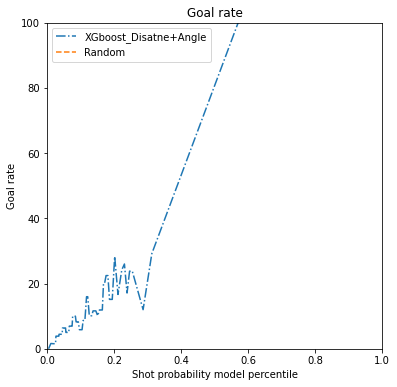

In [16]:
percentiles1, rates1 = compute_goal_rate_per_percentile(XGboost_probsPlayOff, y_PO)
percentiles4, rates4 = compute_goal_rate_per_percentile(random_probs, y_PO)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, linestyle='-.', label='XGboost_Disatne+Angle')
plt.plot(percentiles4, rates4, linestyle='--', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()
plt.ylim([0, 100])
plt.xlim([0, 1])
plt.title('Goal rate')

plt.savefig('../figures/PlayOffs_XGboost-goal_rate_percentile_1.png')

plt.show()

In [ ]:
percentiles1, rates1 = compute_cumulative_propotion_of_goals_per_percentile(XGboost_probsPlayOff, y_PO)

percentiles4, rates4 = compute_cumulative_propotion_of_goals_per_percentile(random_probs, y_PO)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, linestyle='-.', label='XGboost_Disatne+Angle')

plt.plot(percentiles4, rates4, linestyle=':', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative proportion of goals')
plt.legend(loc='lower right')
plt.ylim([0, 100])
plt.xlim([0, 1])
plt.title('Cumulative proportion of goals')

plt.savefig('../figures/PlayOffs_XGboost-goal_rate_percentile_2.png')

plt.show()

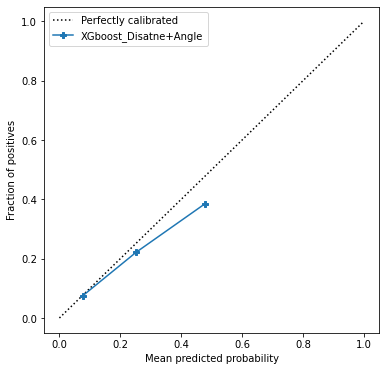

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))


disp1 = CalibrationDisplay.from_estimator(XGboost, X_PO, y_PO, label='XGboost_Disatne+Angle', marker="P", ax=ax)

ax.legend(loc='upper left')

plt.savefig('../figures/PlayOffs_XGboost-calibration_diagram2.png')

plt.show()